In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb

In [2]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet').drop(columns='date_forecast')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet').drop(columns='date_forecast')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet').drop(columns='date_forecast')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet').drop(columns='date_forecast')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet').drop(columns='date_forecast')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet').drop(columns='date_forecast')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet').drop(columns='date_forecast')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet').drop(columns='date_forecast')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet').drop(columns='date_forecast')

In [3]:
obs_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_A.columns]
est_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_A.columns]
test_A.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_A.columns]

obs_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_B.columns]
est_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_B.columns]
test_B.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_B.columns]

obs_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in obs_C.columns]
est_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in est_C.columns]
test_C.columns = [col.replace('[', '').replace(']', '').replace(',', '').replace('{', '').replace('}', '').replace('(', '').replace(')', '').replace('"', '').replace("'", '').replace(':', '').replace('\\', '') for col in test_C.columns]

# Value used in lightGBM
X_train_A = obs_A.drop(columns='pv_measurement')
y_train_A = obs_A['pv_measurement']
X_test_A = est_A.drop(columns='pv_measurement')
y_test_A = est_A['pv_measurement']

X_train_B = obs_B.drop(columns='pv_measurement')
y_train_B = obs_B['pv_measurement']
X_test_B = est_B.drop(columns='pv_measurement')
y_test_B = est_B['pv_measurement']

X_train_C = obs_C.drop(columns='pv_measurement')
y_train_C = obs_C['pv_measurement']
X_test_C = est_C.drop(columns='pv_measurement')
y_test_C = est_C['pv_measurement']



In [4]:

train_data_A = lgb.Dataset(X_train_A, label=y_train_A)
val_data_A = lgb.Dataset(X_test_A, label=y_test_A, reference=train_data_A)

train_data_B = lgb.Dataset(X_train_B, label=y_train_B)
val_data_B = lgb.Dataset(X_test_B, label=y_test_B, reference=train_data_B)

train_data_C = lgb.Dataset(X_train_C, label=y_train_C)
val_data_C = lgb.Dataset(X_test_C, label=y_test_C, reference=train_data_C)

# Set the parameters for the model
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'verbose': 1
}

In [5]:
# Train the model
gbm_A = lgb.train(params,
                train_data_A,
                num_boost_round=500,
                valid_sets=[val_data_A],
                early_stopping_rounds=50,
                verbose_eval=50)

gbm_B = lgb.train(params,
                train_data_B,
                num_boost_round=500,
                valid_sets=[val_data_B],
                early_stopping_rounds=50,
                verbose_eval=50)

gbm_C = lgb.train(params,
                train_data_C,
                num_boost_round=500,
                valid_sets=[val_data_C],
                early_stopping_rounds=50,
                verbose_eval=50)

/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16509
[LightGBM] [Info] Number of data points in the train set: 29624, number of used features: 71
[LightGBM] [Info] Start training from score 675.124060


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 225.344
[100]	valid_0's l1: 155.174
[150]	valid_0's l1: 142.575
[200]	valid_0's l1: 136.964
[250]	valid_0's l1: 134.2
[300]	valid_0's l1: 135.314
[350]	valid_0's l1: 132.946
[400]	valid_0's l1: 131.212
[450]	valid_0's l1: 129.158
[500]	valid_0's l1: 130.015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16512
[LightGBM] [Info] Number of data points in the train set: 22343, number of used features: 71
[LightGBM] [Info] Start training from score 116.057572


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 34.308
[100]	valid_0's l1: 23.2722
[150]	valid_0's l1: 20.9625
[200]	valid_0's l1: 19.4645
[250]	valid_0's l1: 18.9376
[300]	valid_0's l1: 18.8373
[350]	valid_0's l1: 18.4187
[400]	valid_0's l1: 17.9233
[450]	valid_0's l1: 17.6463
[500]	valid_0's l1: 17.7636
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16481
[LightGBM] [Info] Number of data points in the train set: 18270, number of used features: 71
[LightGBM] [Info] Start training from score 104.227050


/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/mathiasotnes/anaconda3/envs/autogluon/lib/python3.8/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's l1: 30.619
[100]	valid_0's l1: 21.3903
[150]	valid_0's l1: 20.485
[200]	valid_0's l1: 20.9881
[250]	valid_0's l1: 21.4827
[300]	valid_0's l1: 21.7893
[350]	valid_0's l1: 21.635
[400]	valid_0's l1: 22.1133
[450]	valid_0's l1: 22.0767
[500]	valid_0's l1: 22.0009


In [6]:
# Evaluate the model
y_pred_A = gbm_A.predict(X_test_A, num_iteration=gbm_A.best_iteration)
y_pred_B = gbm_B.predict(X_test_B, num_iteration=gbm_B.best_iteration)
y_pred_C = gbm_C.predict(X_test_C, num_iteration=gbm_C.best_iteration)

print('MAE A:', mean_absolute_error(y_test_A, y_pred_A))
print('MAE B:', mean_absolute_error(y_test_B, y_pred_B))
print('MAE C:', mean_absolute_error(y_test_C, y_pred_C))

MAE A: 130.01518576304514
MAE B: 17.763576527365018
MAE C: 22.000879877467828


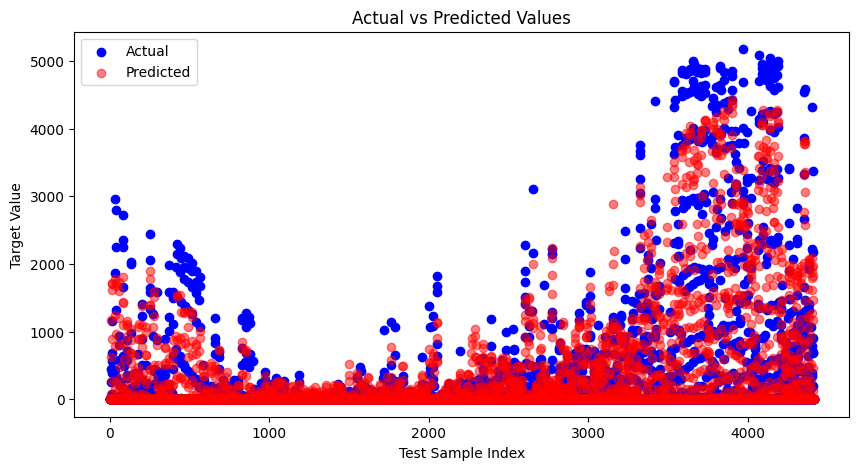

In [7]:
y_pred_A_test = gbm_A.predict(X_test_A)

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_A)), y_test_A, color='blue', label='Actual')
plt.scatter(range(len(y_pred_A_test)), y_pred_A_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()

In [8]:
test_A.describe()

,snow_accumulation,total_radiation,sfc_pressurehPa,month,year,date_forecast_fft_amplitude,date_forecast_fft_phase,sun_elevationd_fft_amplitude,sun_elevationd_fft_phase,clear_sky_radW_rate_of_change,...,cloud_cover_interaction_35,angle_radiation_35,sun_elevation_interaction_75,sun_azimuth_interaction_75,cloud_cover_interaction_75,angle_radiation_75,sun_elevation_interaction_100,sun_azimuth_interaction_100,cloud_cover_interaction_100,angle_radiation_100
count,720.000000,720.000000,720.000000,720.000000,720.0,7.200000e+02,720.000000,720.000000,720.000000,720.000000,...,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.001563,199.684021,1015.920654,5.666667,2023.0,1.697683e+18,-0.004363,65.334998,-0.004363,0.000000,...,72.083534,244.739532,89.124336,59.906761,72.083534,221.114624,51.532101,59.906761,72.083534,183.522400
std,0.029809,215.015656,9.817863,0.596699,0.0,4.523976e+19,2.399267,736.599572,2.397744,83.207748,...,138.896042,424.726257,144.604141,137.897202,138.896042,401.919678,94.228310,137.897202,138.896042,352.419891
min,0.000000,0.000000,985.450012,5.000000,2023.0,1.296000e+15,-3.141593,0.947522,-3.141593,-131.675018,...,0.000000,-0.001640,0.000000,-55.600529,0.000000,-1.773244,-2.384318,-55.600529,0.000000,-9.807020
25%,0.000000,9.068750,1010.487503,5.000000,2023.0,3.072918e+15,-2.356614,4.725976,-2.379941,-61.381248,...,0.000000,0.001888,0.008025,-0.469069,0.000000,0.000000,-0.000000,-0.469069,0.000000,0.000000
50%,0.000000,121.874996,1019.662506,6.000000,2023.0,3.949678e+15,-0.718200,5.980017,-0.283418,0.000000,...,0.402337,15.440804,7.733382,-0.000000,0.402337,8.708270,1.484983,-0.000000,0.402337,2.839834
75%,0.000000,343.337494,1023.031265,6.000000,2023.0,7.183007e+15,2.354935,11.549801,2.377725,65.218752,...,66.324636,305.096733,122.119385,29.777870,66.324636,256.505722,55.499397,29.777870,66.324636,183.248676
max,0.625000,764.924988,1028.699951,7.000000,2023.0,1.213921e+21,3.139914,14611.998002,3.141193,132.500000,...,662.875000,1966.702515,601.991760,667.454834,662.875000,1924.816650,423.422516,667.454834,662.875000,1748.945190


In [9]:
# Create submission

output_file = 'LGBM_submission.csv'

pred_A = gbm_A.predict(test_A)
pred_B = gbm_B.predict(test_B)
pred_C = gbm_C.predict(test_C)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

Submission saved to LGBM_submission.csv


In [15]:
gbm_A.params

{'boosting_type': 'dart',
 'objective': 'regression',
 'metric': 'mae',
 'num_leaves': 100,
 'learning_rate': 0.05,
 'verbose': 1,
 'num_iterations': 500,
 'early_stopping_round': 50}